In [3]:
from skl2onnx import __max_supported_opset__
print (f"Last supported opset: {__max_supported_opset__}")

Last supported opset: 17


# First Example
[source](https://onnx.ai/sklearn-onnx/)

In [6]:
# Train a model
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = RandomForestClassifier()
clr.fit(X_train, y_train)

# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [("float_input", FloatTensorType([None, 4]))]
onx = convert_sklearn(clr, initial_types=initial_type)
with open("rf_iris.onnx", "wb") as f:
    f.write(onx.SerializeToString())

# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("rf_iris.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onnx = sess.run([label_name],
                     {input_name: X_test.astype(numpy.float32)})[0]

In [7]:
pred_onnx

array([0, 0, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2,
       1, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 0, 2, 1, 2, 0], dtype=int64)

# The easy case
[source](https://onnx.ai/sklearn-onnx/tutorial_1_simple.html)

In [24]:
from pyquickhelper.helpgen.graphviz_helper import plot_graphviz
import numpy
from onnxruntime import InferenceSession
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skl2onnx import to_onnx
from mlprodict.onnxrt import OnnxInference

import matplotlib.pyplot as plt

In [12]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=5)
reg2 = RandomForestRegressor(random_state=1, n_estimators=5)
reg3 = LinearRegression()

ereg = Pipeline(steps=[
    ('voting', VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)]))
])
ereg.fit(X_train, y_train)

Pipeline(steps=[('voting',
                 VotingRegressor(estimators=[('gb',
                                              GradientBoostingRegressor(n_estimators=5,
                                                                        random_state=1)),
                                             ('rf',
                                              RandomForestRegressor(n_estimators=5,
                                                                    random_state=1)),
                                             ('lr', LinearRegression())]))])

In [13]:
onx = to_onnx(ereg, X_train[:1].astype(numpy.float32), target_opset=12)

In [14]:
sess = InferenceSession(onx.SerializeToString())
pred_ort = sess.run(None,
                    {'X': X_test.astype(numpy.float32)})[0]
pred_skl = ereg.predict(X_test.astype(numpy.float32))
print(f"Onnx Runtime prediction = {pred_ort[:5]}")
print(f"Sklearn prediction = {pred_skl[:5]}")

Onnx Runtime prediction = [[ 93.73589]
 [132.11148]
 [156.2023 ]
 [183.2326 ]
 [127.60086]]
Sklearn prediction = [ 93.73588828 132.11147757 156.20229314 183.23259903 127.60084971]


In [16]:
def diff(p1, p2):
    p1 = p1.ravel()
    p2 = p2.ravel()
    d = numpy.abs(p2 - p1)
    return d.max(), (d / numpy.abs(p1)).max()

print(diff(pred_skl, pred_ort))

(2.1395257135736756e-05, 1.700824362323645e-07)


In [18]:
oinf = OnnxInference(onx, runtime="python_compiled")
print(oinf)

OnnxInference(...)
    def compiled_run(dict_inputs, yield_ops=None, context=None, attributes=None):
        if yield_ops is not None:
            raise NotImplementedError('yields_ops should be None.')
        # init: w0 (w0)
        # inputs
        X = dict_inputs['X']
        (var_0, ) = n0_treeensembleregressor_1(X)
        (var_2, ) = n1_linearregressor(X)
        (var_1, ) = n2_treeensembleregressor_1(X)
        (wvar_0, ) = n3_mul(var_0, w0)
        (wvar_1, ) = n4_mul(var_1, w0)
        (wvar_2, ) = n5_mul(var_2, w0)
        (fvar_0, ) = n6_flatten(wvar_0)
        (fvar_1, ) = n7_flatten(wvar_1)
        (fvar_2, ) = n8_flatten(wvar_2)
        (variable, ) = n9_sum(fvar_0, fvar_1, fvar_2)
        return {
            'variable': variable,
        }


In [19]:
pred_pyrt=oinf.run({'X': X_test.astype(numpy.float32)})['variable']
print(diff(pred_skl, pred_pyrt))

(2.3300289598182644e-05, 2.1230039077677059e-07)


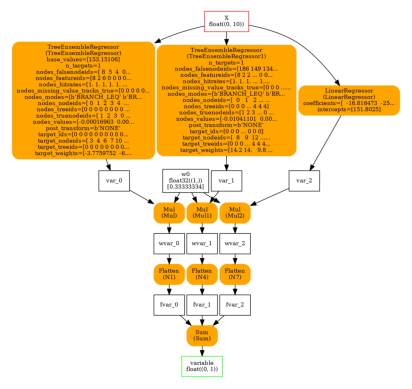

In [26]:
ax = plot_graphviz(oinf.to_dot())
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# A custom converter for a custom model
[source](https://onnx.ai/sklearn-onnx/tutorial_2_new_converter.html)

In [ ]:
[0, 40, 0, 27.5]
...
s = [5, 40, 0, 27.5]

s[0] -> LED_0
s[1] -> HALO_0
s[-1] -> OTHER


-